In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os


Loading data

In [21]:
file_path = '/content/Data Analyst Intern Assignment - Excel.xlsx'  # Replace with the actual file path
user_details = pd.read_excel(file_path, sheet_name='UserDetails.csv')
cooking_sessions = pd.read_excel(file_path, sheet_name='CookingSessions.csv')
order_details = pd.read_excel(file_path, sheet_name='OrderDetails.csv')


Data inspection


In [22]:
user_details.head()

,User ID,User Name,Age,Location,Registration Date,Phone,Email,Favorite Meal,Total Orders
0,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12
1,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8
2,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15
3,U004,David Brown,27,San Francisco,2023-04-05,444-333-2222,david@email.com,Dinner,10
4,U005,Emma White,30,Seattle,2023-05-22,777-888-9999,emma@email.com,Lunch,9


In [23]:
cooking_sessions.head()

,Session ID,User ID,Dish Name,Meal Type,Session Start,Session End,Duration (mins),Session Rating
0,S001,U001,Spaghetti,Dinner,2024-12-01 19:00:00,2024-12-01 19:30:00,30,4.5
1,S002,U002,Caesar Salad,Lunch,2024-12-01 12:00:00,2024-12-01 12:20:00,20,4.0
2,S003,U003,Grilled Chicken,Dinner,2024-12-02 19:30:00,2024-12-02 20:10:00,40,4.8
3,S004,U001,Pancakes,Breakfast,2024-12-02 07:30:00,2024-12-02 08:00:00,30,4.2
4,S005,U004,Caesar Salad,Lunch,2024-12-03 13:00:00,2024-12-03 13:15:00,15,4.7


In [24]:
order_details.head()

,Order ID,User ID,Order Date,Meal Type,Dish Name,Order Status,Amount (USD),Time of Day,Rating,Session ID
0,1001,U001,2024-12-01,Dinner,Spaghetti,Completed,15.0,Night,5.0,S001
1,1002,U002,2024-12-01,Lunch,Caesar Salad,Completed,10.0,Day,4.0,S002
2,1003,U003,2024-12-02,Dinner,Grilled Chicken,Canceled,12.5,Night,NaN,S003
3,1004,U001,2024-12-02,Breakfast,Pancakes,Completed,8.0,Morning,4.0,S004
4,1005,U004,2024-12-03,Lunch,Caesar Salad,Completed,9.0,Day,4.0,S005


In [25]:
user_details.isnull().sum()

,0
User ID,0
User Name,0
Age,0
Location,0
Registration Date,0
Phone,0
Email,0
Favorite Meal,0
Total Orders,0


In [26]:
cooking_sessions.isnull().sum()

,0
Session ID,0
User ID,0
Dish Name,0
Meal Type,0
Session Start,0
Session End,0
Duration (mins),0
Session Rating,0


In [27]:
order_details.isnull().sum()

,0
Order ID,0
User ID,0
Order Date,0
Meal Type,0
Dish Name,0
Order Status,0
Amount (USD),0
Time of Day,0
Rating,2
Session ID,0


Clean and Preprocess Data

In [28]:

user_details.columns = user_details.columns.str.strip().str.lower().str.replace(' ', '_')
cooking_sessions.columns = cooking_sessions.columns.str.strip().str.lower().str.replace(' ', '_')
order_details.columns = order_details.columns.str.strip().str.lower().str.replace(' ', '_')

order_details['rating'] = order_details['rating'].fillna(order_details['rating'].mean())

user_details['registration_date'] = pd.to_datetime(user_details['registration_date'])
cooking_sessions['session_start'] = pd.to_datetime(cooking_sessions['session_start'])
cooking_sessions['session_end'] = pd.to_datetime(cooking_sessions['session_end'])
order_details['order_date'] = pd.to_datetime(order_details['order_date'])

cooking_sessions['session_duration'] = (
    (cooking_sessions['session_end'] - cooking_sessions['session_start']).dt.seconds / 60
)


In [29]:
order_details.isnull().sum()

,0
order_id,0
user_id,0
order_date,0
meal_type,0
dish_name,0
order_status,0
amount_(usd),0
time_of_day,0
rating,0
session_id,0


Merge Data

In [30]:
merged_data = pd.merge(cooking_sessions, user_details, on='user_id', how='inner')
final_data = pd.merge(merged_data, order_details, on=['user_id', 'session_id'], how='inner')

if 'meal_type' in cooking_sessions.columns:
    final_data['meal_type'] = cooking_sessions['meal_type']
elif 'meal_type' in order_details.columns:
    final_data['meal_type'] = order_details['meal_type']
else:
    print("Warning: 'meal_type' column not found in either dataset.")


Data Analysis

In [31]:
if final_data is not None and not final_data.empty:
    os.makedirs('outputs', exist_ok=True)

    final_data.to_csv('outputs/cleaned_data.csv', index=False)

orders_by_session = final_data.groupby('session_id')['order_id'].count()
print("Average orders per session:", orders_by_session.mean())

if 'dish_name_x' in final_data.columns:
    popular_dishes = final_data['dish_name_x'].value_counts()
    print("\nTop 5 popular dishes:\n", popular_dishes.head())
else:
    print("\nDish name column not found in final_data.")

age_orders = final_data.groupby('age')['order_id'].count()
print("\nOrders by Age Group:\n", age_orders)

location_orders = final_data.groupby('location')['order_id'].count()
print("\nOrders by Location:\n", location_orders)

if 'meal_type' in final_data.columns:
    meal_type_orders = final_data.groupby('meal_type')['order_id'].count()
    print("\nOrders by Meal Type:\n", meal_type_orders)
else:
    print("\nMeal type column not found in final_data.")

if 'meal_type' in final_data.columns and 'session_duration' in final_data.columns:
    avg_duration_by_meal = final_data.groupby('meal_type')['session_duration'].mean()
    print("\nAverage Session Duration by Meal Type (minutes):\n", avg_duration_by_meal)
else:
    print("\nMeal type or session duration column not found in final_data.")

if 'rating' in final_data.columns:
    rating_distribution = final_data['rating'].value_counts().sort_index()
    print("\nRatings Distribution:\n", rating_distribution)

if 'order_date' in final_data.columns:
    monthly_orders = final_data.groupby(final_data['order_date'].dt.to_period('M'))['order_id'].count()
    print("\nMonthly Orders:\n", monthly_orders)

numeric_data = final_data.select_dtypes(include=np.number)
if not numeric_data.empty:
    correlation_matrix = numeric_data.corr()
    print("\nCorrelation Matrix:\n", correlation_matrix)

if 'location' in final_data.columns and 'age' in final_data.columns:
    location_age_pivot = final_data.pivot_table(index='location', columns='age', values='order_id', aggfunc='count', fill_value=0)
    print("\nOrder Frequency by Location and Age Group:\n", location_age_pivot)

else:
    print("Final data is empty or not available, skipping further analysis.")

Average orders per session: 1.0

Top 5 popular dishes:
 dish_name_x
Spaghetti          4
Grilled Chicken    4
Caesar Salad       3
Pancakes           2
Veggie Burger      2
Name: count, dtype: int64

Orders by Age Group:
 age
25    1
27    2
28    3
30    2
31    1
35    3
38    1
42    3
Name: order_id, dtype: int64

Orders by Location:
 location
Austin           1
Boston           1
Chicago          3
Los Angeles      3
Miami            1
New York         3
San Francisco    2
Seattle          2
Name: order_id, dtype: int64

Orders by Meal Type:
 meal_type
Breakfast    3
Dinner       8
Lunch        5
Name: order_id, dtype: int64

Average Session Duration by Meal Type (minutes):
 meal_type
Breakfast    23.333333
Dinner       38.750000
Lunch        21.000000
Name: session_duration, dtype: float64

Ratings Distribution:
 rating
4.000000    10
4.285714     2
5.000000     4
Name: count, dtype: int64

Monthly Orders:
 order_date
2024-12    16
Freq: M, Name: order_id, dtype: int64

Correlati


Enhanced Visualizations

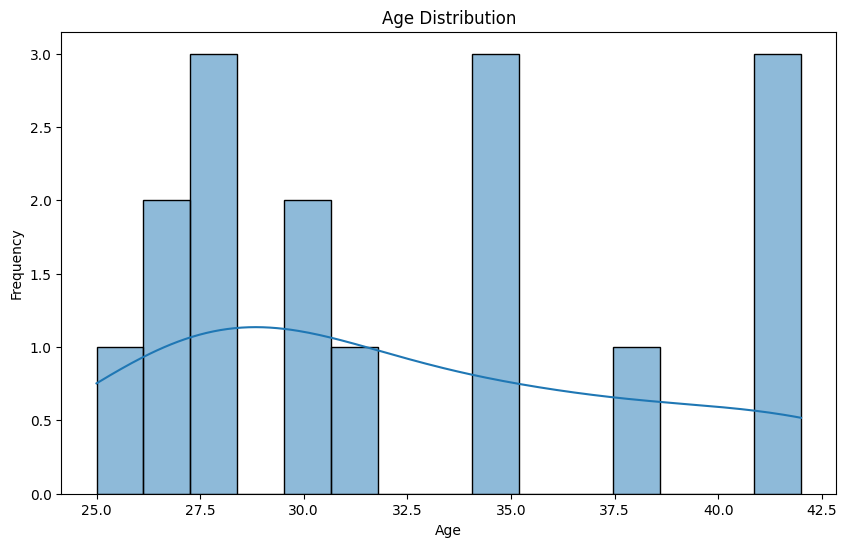

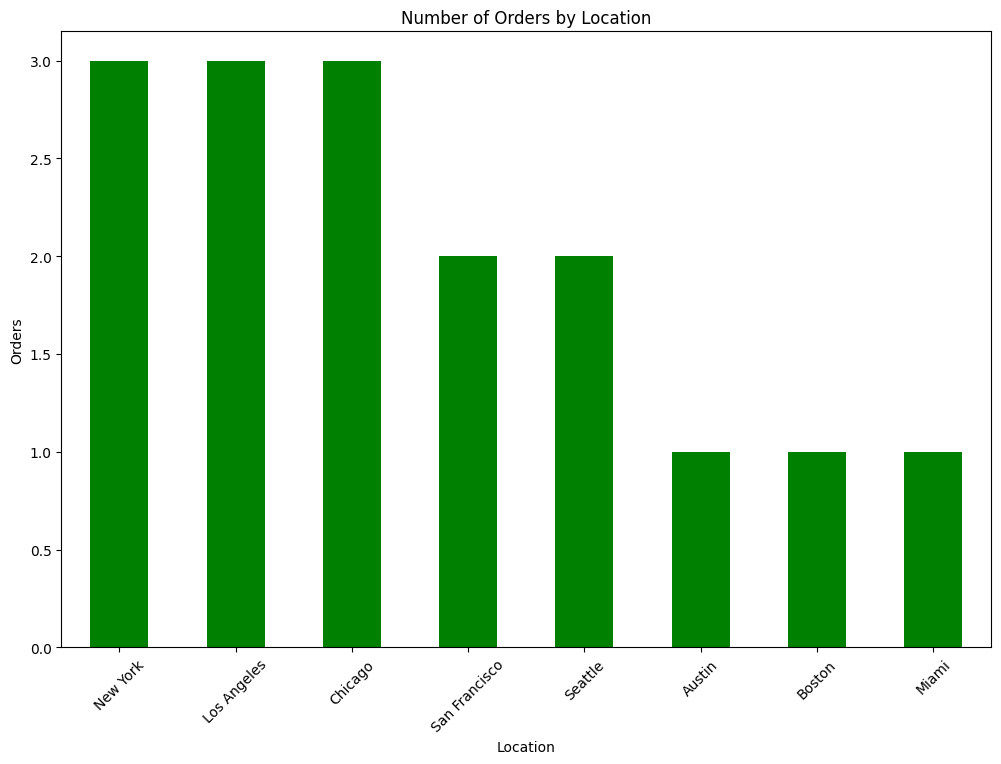

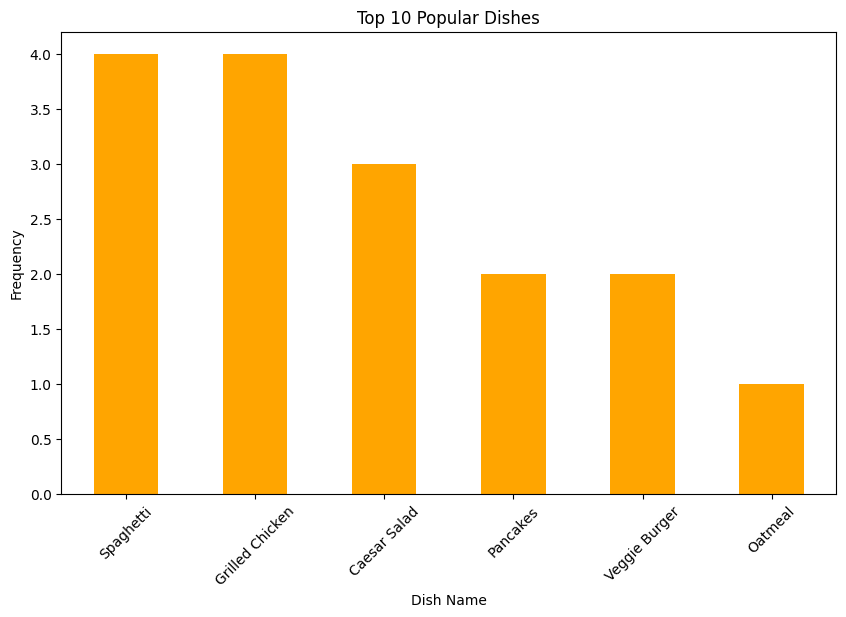

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


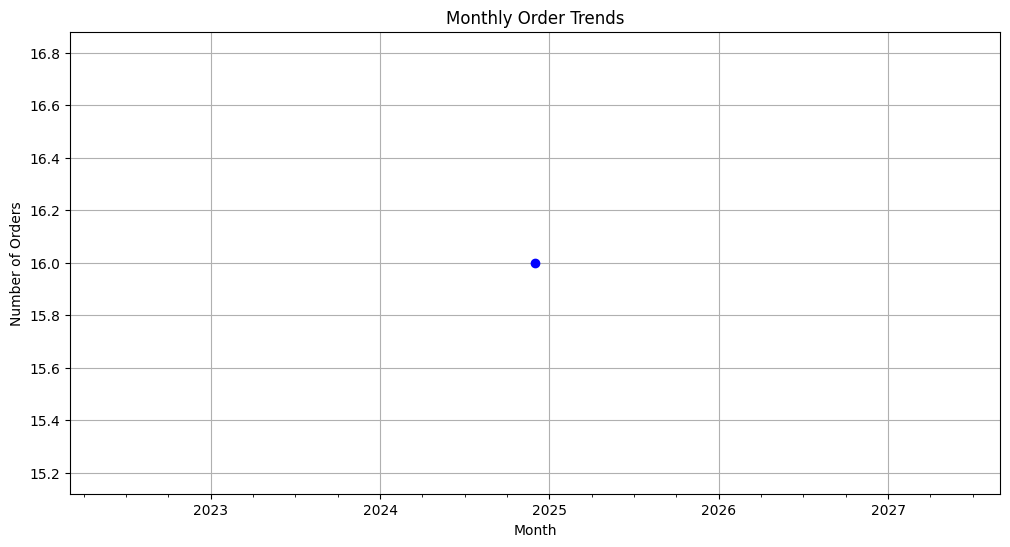

<ipython-input-32-d15bf1859d2f>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_data, x='meal_type', y='rating', palette='Set2')


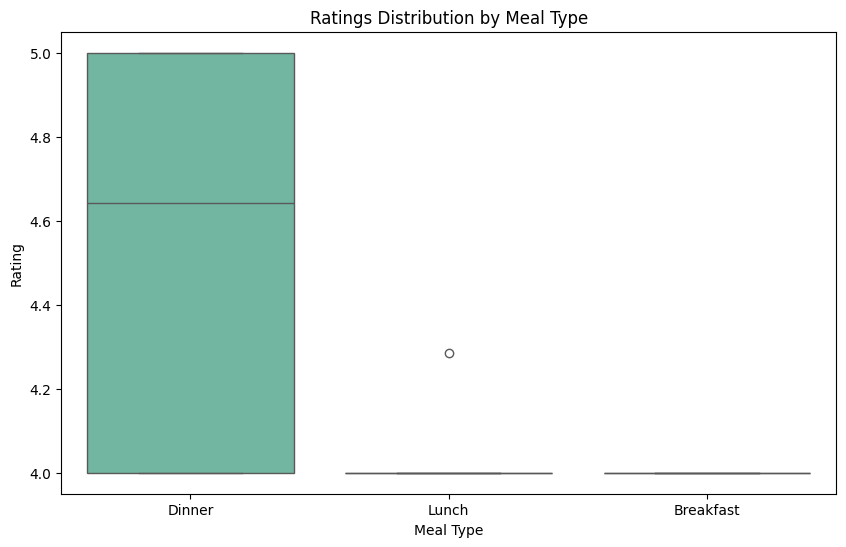

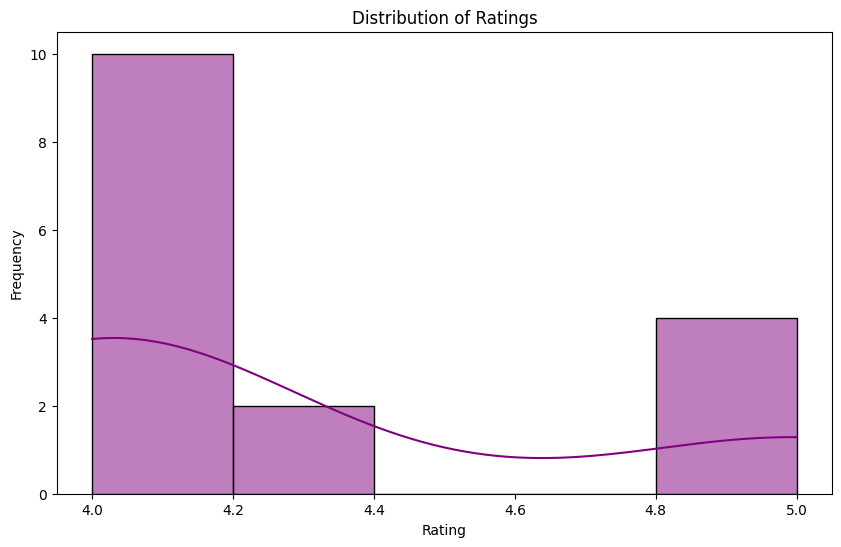

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


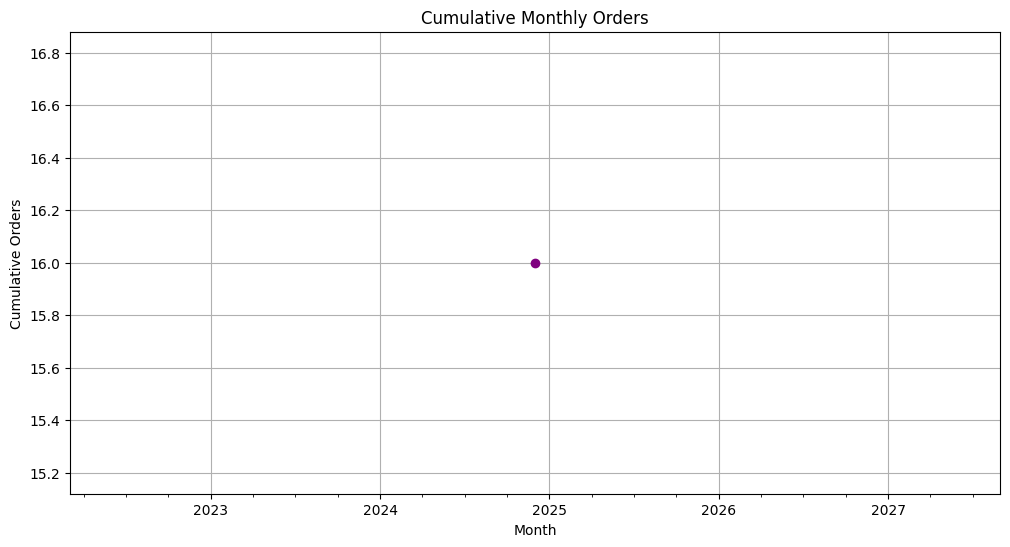

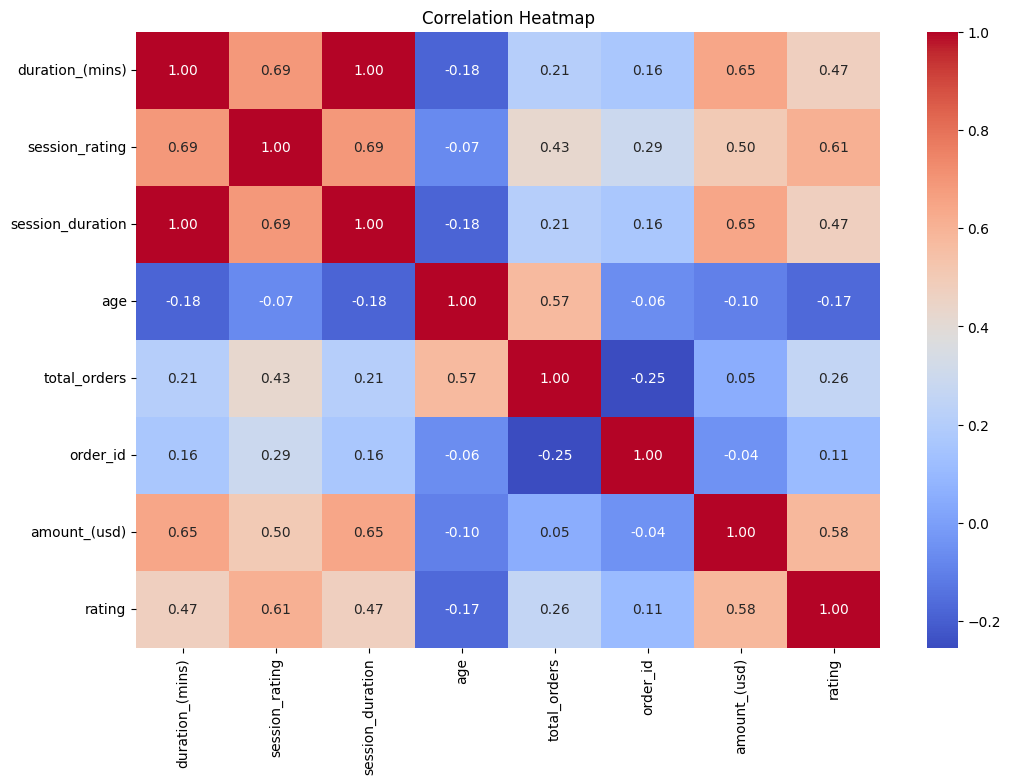

<Figure size 1000x600 with 0 Axes>

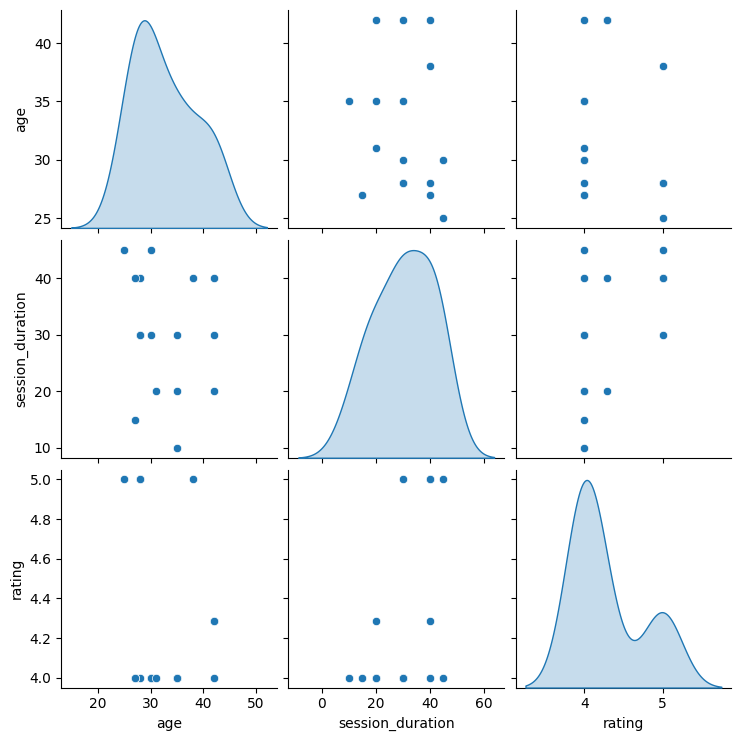

In [32]:
os.makedirs('outputs', exist_ok=True)

plt.figure(figsize=(10, 6))
sns.histplot(final_data['age'], kde=True, bins=15)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('outputs/age_distribution.png')
plt.show()

location_distribution = final_data['location'].value_counts()
plt.figure(figsize=(12, 8))
location_distribution.plot(kind='bar', color='green')
plt.title('Number of Orders by Location')
plt.xlabel('Location')
plt.ylabel('Orders')
plt.xticks(rotation=45)
plt.savefig('outputs/orders_by_location.png')
plt.show()

if popular_dishes is not None:
    plt.figure(figsize=(10, 6))
    popular_dishes.head(10).plot(kind='bar', color='orange')
    plt.title('Top 10 Popular Dishes')
    plt.xlabel('Dish Name')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.savefig('outputs/popular_dishes.png')
    plt.show()

final_data['month'] = final_data['order_date'].dt.to_period('M')
monthly_trends = final_data.groupby('month')['order_id'].count()

plt.figure(figsize=(12, 6))
monthly_trends.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Order Trends')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid()
plt.savefig('outputs/monthly_order_trends.png')
plt.show()

if 'meal_type' in final_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=final_data, x='meal_type', y='rating', palette='Set2')
    plt.title('Ratings Distribution by Meal Type')
    plt.xlabel('Meal Type')
    plt.ylabel('Rating')
    plt.savefig('outputs/ratings_by_meal_type.png')
    plt.show()

if 'rating' in final_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(final_data['rating'], kde=True, color='purple')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.savefig('outputs/ratings_distribution.png')
    plt.show()

cumulative_orders = monthly_trends.cumsum()
plt.figure(figsize=(12, 6))
cumulative_orders.plot(kind='line', marker='o', color='purple')
plt.title('Cumulative Monthly Orders')
plt.xlabel('Month')
plt.ylabel('Cumulative Orders')
plt.grid()
plt.savefig('outputs/cumulative_orders.png')
plt.show()

plt.figure(figsize=(12, 8))
numeric_data = final_data.select_dtypes(include=np.number)
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('outputs/correlation_heatmap.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.pairplot(final_data[['age', 'session_duration', 'rating']], diag_kind='kde')
plt.savefig('outputs/pairplot_features.png')
plt.show()


Generate Summary Report

In [33]:
orders_by_session = final_data.groupby('session_id')['order_id'].count()
if 'dish_name_x' in final_data.columns:
    popular_dishes = final_data['dish_name_x'].value_counts()
else:
    popular_dishes = None

age_orders = final_data.groupby('age')['order_id'].count()
location_orders = final_data.groupby('location')['order_id'].count()

if 'meal_type' in final_data.columns:
    meal_type_orders = final_data.groupby('meal_type')['order_id'].count()
else:
    meal_type_orders = None

if 'session_duration' in final_data.columns and 'meal_type' in final_data.columns:
    avg_duration_by_meal = final_data.groupby('meal_type')['session_duration'].mean()
else:
    avg_duration_by_meal = None

if 'order_date' in final_data.columns:
    monthly_orders = final_data.groupby(final_data['order_date'].dt.to_period('M'))['order_id'].count()
else:
    monthly_orders = None

summary_report = """
# Data Analysis Summary Report

## Key Findings:
1. **Average Orders per Session**:
   The average number of orders per cooking session is {:.2f}.

2. **Popular Dishes**:
   Top 5 most popular dishes:
   {}

3. **Demographic Insights**:
   - The age group with the highest number of orders is {} years.
   - The location with the highest number of orders is {}.

4. **Meal Type Insights**:
   {}

5. **Session Duration Analysis**:
   {}

6. **Monthly Trends**:
   {}

## Business Recommendations:
- Focus marketing on the top-performing dishes.
- Target high-order age groups and locations to maximize engagement.
- Enhance meal-specific promotions to increase session durations.
- Use monthly trends to predict demand and optimize resource allocation.
""".format(
    orders_by_session.mean(),
    "\n   ".join(f"- {dish}" for dish in popular_dishes.head(5).index) if popular_dishes is not None else "Not available",
    age_orders.idxmax(),
    location_orders.idxmax(),
    f"Meal Type with highest orders: {meal_type_orders.idxmax()} ({meal_type_orders.max()} orders)" if meal_type_orders is not None else "Meal type data not available",
    f"Average session duration by meal type:\n{avg_duration_by_meal}" if avg_duration_by_meal is not None else "Session duration data not available",
    f"Monthly orders trend:\n{monthly_orders}" if monthly_orders is not None else "Monthly trends data not available"
)

os.makedirs('outputs', exist_ok=True)
with open('outputs/summary_report.txt', 'w') as f:
    f.write(summary_report)

print("Summary Report Generated:\n")
print(summary_report)


Summary Report Generated:


# Data Analysis Summary Report

## Key Findings:
1. **Average Orders per Session**:
   The average number of orders per cooking session is 1.00.

2. **Popular Dishes**:
   Top 5 most popular dishes:
   - Spaghetti
   - Grilled Chicken
   - Caesar Salad
   - Pancakes
   - Veggie Burger

3. **Demographic Insights**:
   - The age group with the highest number of orders is 28 years.
   - The location with the highest number of orders is Chicago.

4. **Meal Type Insights**:
   Meal Type with highest orders: Dinner (8 orders)

5. **Session Duration Analysis**:
   Average session duration by meal type:
meal_type
Breakfast    23.333333
Dinner       38.750000
Lunch        21.000000
Name: session_duration, dtype: float64

6. **Monthly Trends**:
   Monthly orders trend:
order_date
2024-12    16
Freq: M, Name: order_id, dtype: int64

## Business Recommendations:
- Focus marketing on the top-performing dishes.
- Target high-order age groups and locations to maximize enga

Save Results


In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

os.makedirs('outputs', exist_ok=True)
final_data.to_csv('outputs/cleaned_data.csv', index=False)

readme_content = """
# User Behavior Analysis Project

## Project Overview
This project analyzes datasets related to user behavior, cooking preferences, and order trends.
The objective is to extract insights, identify trends, and provide actionable recommendations to optimize business processes.

## Datasets
1. **UserDetails.csv**: Contains user demographic and registration details.
2. **CookingSessions.csv**: Logs of cooking sessions.
3. **OrderDetails.csv**: Details of user orders.

## Steps Performed
1. **Data Cleaning**: Standardized column names, handled missing values, and transformed date columns.
2. **Data Merging**: Combined datasets for comprehensive analysis.
3. **Data Analysis and Insights**: Explored relationships, identified trends, and extracted key insights.
4. **Visualizations**: Created charts to effectively communicate findings.
5. **Summary Report and Recommendations**: Documented findings in a report for stakeholders.

## Outputs
All generated outputs are stored in the `outputs/` folder:
- `cleaned_data.csv`: Final cleaned and processed dataset.
- `summary_report.txt`: Text-based summary of findings and recommendations.
- Visualization charts (e.g., `age_distribution.png`, `monthly_order_trends.png`, etc.).

## How to Run
1. Ensure you have Python installed along with the required libraries:
"""
os.makedirs('outputs', exist_ok=True)

if final_data is not None:
    final_data.to_csv('outputs/cleaned_data.csv', index=False)
    print("Cleaned data saved successfully.")
else:
    print("Error: final_data is None, cannot save cleaned data.")


Cleaned data saved successfully.


In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from google.colab import files

os.makedirs('outputs', exist_ok=True)

def create_pivot_and_save(data, pivot_file_path, cleaned_data_file_path):
    if 'location' in data.columns and 'age' in data.columns:
        location_age_pivot = data.pivot_table(index='location', columns='age', values='order_id', aggfunc='count', fill_value=0)
    else:
        location_age_pivot = None

    if 'meal_type' in data.columns:
        meal_type_pivot = data.pivot_table(index='meal_type', values='order_id', aggfunc='count', fill_value=0)
    else:
        meal_type_pivot = None

    data.to_csv(cleaned_data_file_path, index=False)
    print(f"Cleaned data saved successfully to {cleaned_data_file_path}")

    with pd.ExcelWriter(pivot_file_path, engine='xlsxwriter') as writer:
        if location_age_pivot is not None:
            location_age_pivot.to_excel(writer, sheet_name='Location_Age_Pivot')
        if meal_type_pivot is not None:
            meal_type_pivot.to_excel(writer, sheet_name='Meal_Type_Pivot')

    print(f"Pivot tables saved successfully to {pivot_file_path}")

pivot_file_path = 'outputs/pivot_analysis.xlsx'
cleaned_data_file_path = 'outputs/cleaned_data.csv'

create_pivot_and_save(final_data, pivot_file_path, cleaned_data_file_path)

print("Files in 'outputs' directory:")
print(os.listdir('outputs'))

files.download(cleaned_data_file_path)
files.download(pivot_file_path)


Cleaned data saved successfully to outputs/cleaned_data.csv
Pivot tables saved successfully to outputs/pivot_analysis.xlsx
Files in 'outputs' directory:
['ratings_by_meal_type.png', 'pairplot_features.png', 'cumulative_orders.png', 'correlation_heatmap.png', 'summary_report.txt', 'ratings_distribution.png', 'monthly_order_trends.png', 'orders_by_location.png', 'age_distribution.png', 'pivot_analysis.xlsx', 'cleaned_data.csv', 'popular_dishes.png']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
readme_content += """
1. Replace `file_path` with your dataset path.
2. Install required Python libraries: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`.
3. Run the script to generate insights and visualizations.
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

Outlier Detection

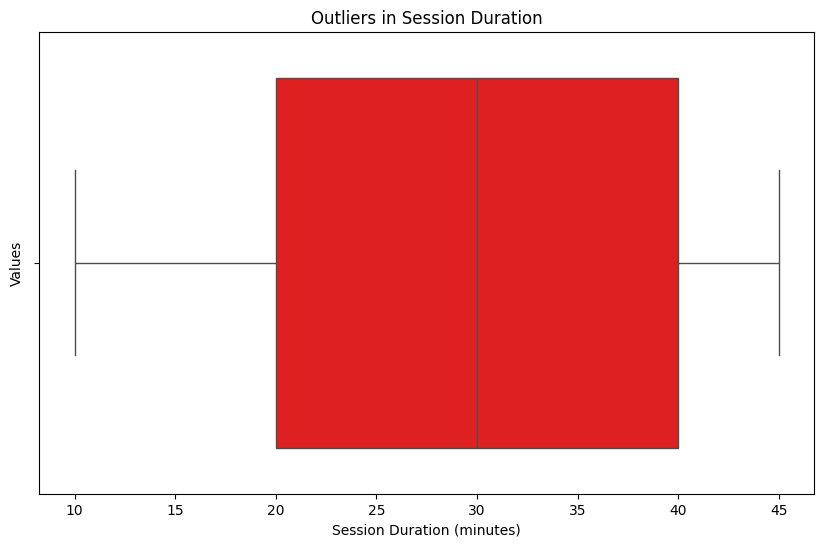

In [37]:
if 'session_duration' in final_data.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=final_data, x='session_duration', color='red')
    plt.title('Outliers in Session Duration')
    plt.xlabel('Session Duration (minutes)')
    plt.ylabel('Values')
    plt.show()
else:
    print("Error: 'session_duration' column not found in final_data.")
